This notebook is a tutorial for training and prediction in data2.

# Load Dependencies

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from rdkit import Chem
from script.MIGNN_model import Graph_DataLoader,MIGNN_model2
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import MultipleLocator
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error

2023-04-13 14:59:42.921497: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-13 14:59:43.023263: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-04-13 14:59:43.500344: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-04-13 14:59:43.500422: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or 

# Load Steric and Electronic Information

In [3]:
react_spms = np.load('./data2/run_data/data2_SEMG_MIGNN_react_spms.npy')
react_elec = np.load('./data2/run_data/data2_SEMG_MIGNN_react_elec.npy')
labels = np.load('./data2/run_data/data2_SEMG_MIGNN_labels.npy')
label_std = np.load('./data2/run_data/data2_SEMG_MIGNN_label_std.npy')

# Train Model

## Interpolative Task

In [4]:
loss = 'mse'
batch_size = 32
shuffle = np.array(list(range(len(react_spms))))
np.random.seed(2021)
np.random.shuffle(shuffle)
train_index = shuffle[:600]
val_index = shuffle[600:]
spms_train,elec_train,y_train = react_spms[train_index],react_elec[train_index],labels[train_index]
spms_val,elec_val,y_val = react_spms[val_index],react_elec[val_index],labels[val_index]
y_train_std=(y_train-y_train.min())/(y_train.max()-y_train.min())
y_val_std=(y_val-y_train.min())/(y_train.max()-y_train.min())
train_gen = Graph_DataLoader(spms_train,elec_train,y_train_std,batch_size=batch_size)
valid_gen = Graph_DataLoader(spms_val,elec_val,y_val_std,batch_size=batch_size)
valid_gen_predict = Graph_DataLoader(spms_val,elec_val,y_val_std,batch_size=batch_size,predict=True)

In [5]:
model = MIGNN_model2(184, 33, 19)
opt = tf.keras.optimizers.Adam()
model.compile(optimizer=opt,loss=loss)
checkpoint = tf.train.Checkpoint(myAwesomeModel=model)
EPOCHS = 50
for epoch in range(EPOCHS):
    hist = model.fit(train_gen,validation_data=valid_gen)
    path = checkpoint.save('./data2/run_data/data2_random.ckpt')
    print("model saved to %s" % path)
opt = tf.keras.optimizers.Adam()
new_model = MIGNN_model2(184, 33, 19)
new_model.compile(optimizer=opt,loss='mse')
_ = new_model.fit(valid_gen,epochs=1)
checkpoint = tf.train.Checkpoint(myAwesomeModel=new_model) 
checkpoint.restore('./data2/run_data/data2_random.ckpt-50') 

y_pred = new_model.predict(valid_gen_predict)
y_pred=y_pred*(y_train.max()-y_train.min())+y_train.min()

2023-02-20 18:59:30.171333: E tensorflow/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: CUDA_ERROR_INVALID_DEVICE: invalid device ordinal
2023-02-20 18:59:30.171417: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: c0ee79c535f7
2023-02-20 18:59:30.171439: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: c0ee79c535f7
2023-02-20 18:59:30.171658: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 495.29.5
2023-02-20 18:59:30.178240: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 495.29.5
2023-02-20 18:59:30.178287: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 495.29.5
2023-02-20 18:59:30.179140: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in

19/19 [==============================] - 9s 356ms/step - loss: 0.0722 - val_loss: 0.0459
model saved to ./data2/run_data/data2_random.ckpt-1
19/19 [==============================] - 7s 361ms/step - loss: 0.0414 - val_loss: 0.0369
model saved to ./data2/run_data/data2_random.ckpt-2
19/19 [==============================] - 7s 360ms/step - loss: 0.0304 - val_loss: 0.0443
model saved to ./data2/run_data/data2_random.ckpt-3
19/19 [==============================] - 7s 363ms/step - loss: 0.0218 - val_loss: 0.0266
model saved to ./data2/run_data/data2_random.ckpt-4
19/19 [==============================] - 7s 361ms/step - loss: 0.0168 - val_loss: 0.0249
model saved to ./data2/run_data/data2_random.ckpt-5
19/19 [==============================] - 7s 361ms/step - loss: 0.0101 - val_loss: 0.0131
model saved to ./data2/run_data/data2_random.ckpt-6
19/19 [==============================] - 7s 363ms/step - loss: 0.0067 - val_loss: 0.0148
model saved to ./data2/run_data/data2_random.ckpt-7
19/19 [======

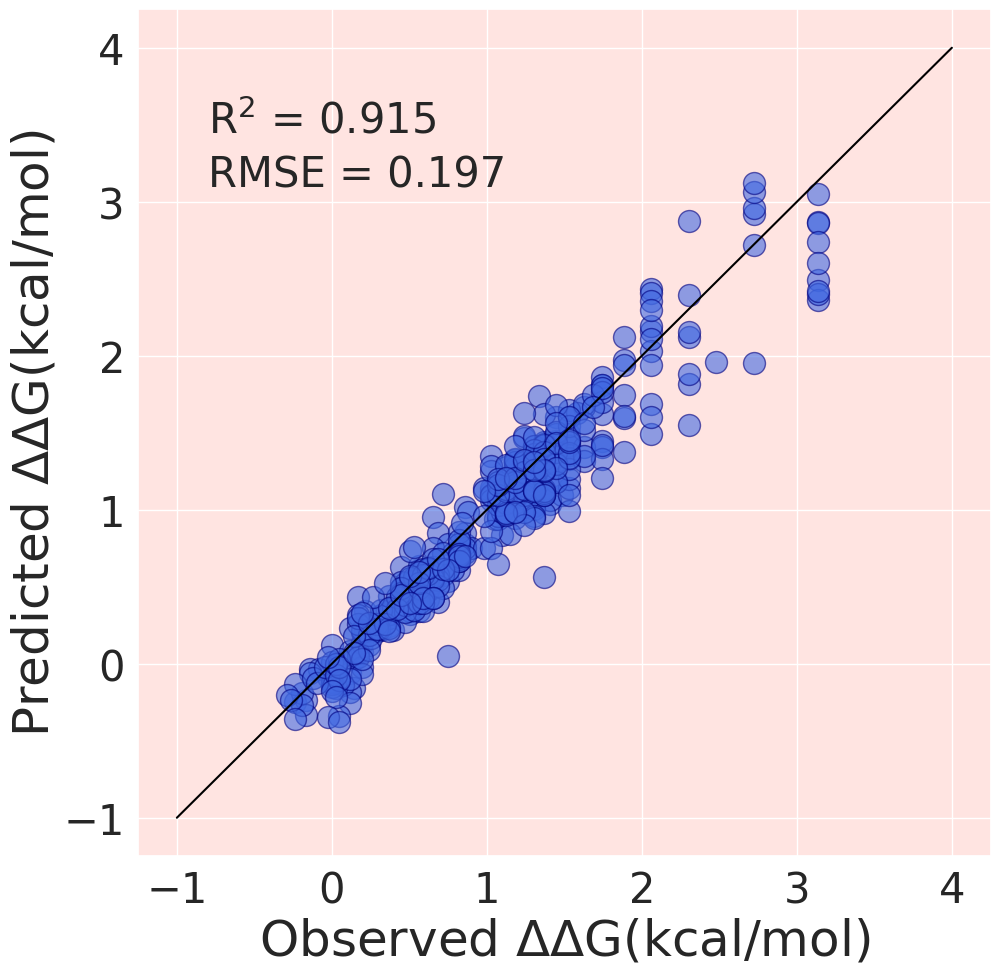

In [8]:
sns.set(style='darkgrid')
fig = plt.figure(figsize=(11,11),facecolor='white',   
           edgecolor='black')
plt.scatter(y_val,y_pred,s=250, c='royalblue', label="samples",alpha=0.6,edgecolors='navy')
plt.plot([-1,4],[-1,4],c='black')
ax=plt.gca()
ax.set_facecolor('mistyrose')
plt.xlabel("Observed $\Delta$$\Delta$G(kcal/mol)",fontsize=36)
plt.ylabel("Predicted $\Delta$$\Delta$G(kcal/mol)",fontsize=36)
plt.tick_params(labelsize=30)
plt.text(-0.8,3.1,'RMSE = %.3f'%(mean_squared_error(y_val,y_pred))**(0.5),fontsize=30)
plt.text(-0.8,3.45,'R$^2$ = %.3f'%r2_score(y_val,y_pred),fontsize=30)
plt.show()